In [2]:
%matplotlib qt
%pylab qt
import numpy as np
from pylab import *
import os, sys
#from os.path import basename
#import time
#import itertools
from numpy import pi
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, LogLocator
from matplotlib import rc
rc('font',**{'family':'serif'})  # fontype matching Latex
import matplotlib.pyplot as plt


#plt.rc('axes', linewidth=2)
import matplotlib.ticker
#%matplotlib inline
#%matplotlib notebook 
from scipy.interpolate import interp1d


import glob
import pylab
#pylab.rcParams['figure.figsize'] = (8.0, 6.0)
import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# ========================================= #
# =============   Universal   ============= #
# ========================================= #

def _is_evenly_spaced(arr):
    """Check if an array has evenly spaced elements (linear)"""
    cond = np.allclose((arr[1:]-arr[:-1]), (arr[1]-arr[0]))
    return cond


def _bin_midpoints(bin_edges):
    return 0.5*(bin_edges[:-1] + bin_edges[1:])


# ================================================= #
# =============   3D Power Spectrum   ============= #
# ================================================= #

def real_to_fourier3d(f, x, y, z):
    # Check that real-space grid spacing is all equal
    if not (_is_evenly_spaced(x) and _is_evenly_spaced(y) and _is_evenly_spaced(z)):
        raise ValueError('Sample points in real space are not evenly spaced.')
    dx = x[1]-x[0]  # Grid spacing
    dy = y[1]-y[0]
    dz = z[1]-z[0]
    
    #ftrans  = np.fft.rfftn(f)
    ftrans  = np.fft.rfftn(f.T).T

    # Wavenumber arrays
    kx = 2*np.pi * np.fft.rfftfreq(x.size, d=dx)
    ky = 2*np.pi * np.fft.fftfreq(y.size, d=dy)
    kz = 2*np.pi * np.fft.fftfreq(z.size, d=dz)

    # Normalize (convert DFT to continuous FT)
    ftrans *= dx*dy*dz

    return ftrans, kx, ky, kz


def real_to_pow3d(f, x, y, z):
    """Calculate a 3D power spectrum, given:
    -- a function defined on a 3D grid of evenly-spaced (x,y,z) points
    -- a 1D array of the sampled points in each dimension (x,y,z)
    """
    
    ftrans, kx, ky, kz  = real_to_fourier3d(f, x, y, z)
    
    # "Power spectrum" = power spectral density = |FT|^2 / volume
    vol = np.abs( (x[-1]-x[0])*(y[-1]-y[0])*(z[-1]-z[0]) ) # Total volume
    power = np.abs(ftrans)**2./vol 
    
    
    #print('\n ftrans has shape: ', power.shape)
    
    return power, kx, ky, kz
    

def real_to_pow3d_cross(f1, f2, x, y, z):
    """Calculate a 3D power spectrum, given:
    -- a function defined on a 3D grid of evenly-spaced (x,y,z) points
    -- a 1D array of the sampled points in each dimension (x,y,z)
    """
    
    ftrans1, kx, ky, kz  = real_to_fourier3d(f1, x, y, z)
    ftrans2, kx, ky, kz  = real_to_fourier3d(f2, x, y, z)
    
    # "Power spectrum" = power spectral density = |FT|^2 / volume
    vol = np.abs( (x[-1]-x[0])*(y[-1]-y[0])*(z[-1]-z[0]) ) # Total volume
    #power = np.abs(ftrans)**2./vol 
    #power = np.abs(ftrans1)*np.abs(ftrans2)/vol
    power = np.real(ftrans1*np.conjugate(ftrans2))/vol
    
    #print('\n ftrans has shape: ', power.shape)
    
    return power, kx, ky, kz
    
    
def xyz_to_rsphbins(x, y, z, bins=None, log=False):
    rmin = 0
    rmax = max(np.amax(np.abs(x)), np.amax(np.abs(y)), np.amax(np.abs(z)))
    
    if bins == None:
        dr = max( [ np.min(np.abs(q[ q!=0 ])) for q in (x,y,z) ] ) # Smallest nonzero, absolute x,y,z coordinate value
        bins = int( np.ceil((rmax-rmin)/dr) )
        if log:
            _rmin = min(np.min(np.abs(x)), np.min(np.abs(y)), np.min(np.abs(z)))
            if _rmin==0.: 
                _rmin = min(np.partition(np.abs(x), 2)[1], np.partition(np.abs(y), 2)[1], np.partition(np.abs(z), 2)[1])
                _rmin = _rmin / 0.3
                #print('_rmin:', _rmin)
            rsphbins = np.logspace(np.log10(_rmin), np.log10(bins*dr), bins+1)
        else:
            rsphbins = np.linspace(0, bins*dr, bins+1)
    else:
        if log:
            _rmin = min(np.min(np.abs(x)), np.min(np.abs(y)), np.min(np.abs(z)))
            if _rmin==0.: 
                _rmin = min(np.partition(np.abs(x), 2)[1], np.partition(np.abs(y), 2)[1], np.partition(np.abs(z), 2)[1])
                _rmin = _rmin / 0.3
                #print('_rmin:', _rmin)
            rsphbins    = np.logspace(np.log10(_rmin), np.log10(rmax), bins+1)
        else:
            rsphbins    = np.linspace(rmin, rmax, bins+1)
    
    return rsphbins


def f3d_to_fsphavg(f, x, y, z, bins=None, log=False):
    rsphbins   = xyz_to_rsphbins(x, y, z, bins=bins, log=log)
    #print('rsphbins: ', rsphbins)
    f[np.where(f==0.0)] = np.min(f)
    rr      = np.sqrt( sum(xx**2 for xx in np.meshgrid(x, y, z, indexing='ij')) ) # 2d grid of r (distance from origin)
    gt0     = np.where(rr > 0) # selection for r>0 (do not include origin)
    fofr    = np.histogram(rr[gt0], bins=rsphbins, weights=f[gt0])[0] / np.histogram(rr[gt0], bins=rsphbins)[0]
    rmid    = _bin_midpoints(rsphbins)

    return rmid, fofr

In [4]:
# To normalize the midpoint of the colorbar


def load_binary_data(filename, dtype=np.float32):
    """
    We assume that the data was written
    with write_binary_data() (little endian).
    """
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.fromstring(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

def CreateDataCube(path):


    # read in the data cube located in 21cmFast/Boxes/delta_T*
    data = load_binary_data(path)
    data.shape = (DIM, DIM, DIM)
    data = data.reshape((DIM, DIM, DIM), order='F')
    
    
    return data

In [5]:
def get_ps(D, N, data):
    
    dx = dy = dz = D
    nx_sim = ny_sim = nz_sim = N

    x = np.linspace(-nx_sim/2 + nx_sim%2, nx_sim/2 - 1 + nx_sim%2, nx_sim) * dx
    y = np.linspace(-ny_sim/2 + ny_sim%2, ny_sim/2 - 1 + ny_sim%2, ny_sim) * dy
    z = np.linspace(-nz_sim/2 + nz_sim%2, nz_sim/2 - 1 + nz_sim%2, nz_sim) * dz

    f_3d, kx, ky, kz = real_to_pow3d(data, x, y, z)
    rmid, fofr = f3d_to_fsphavg(f_3d, kx, ky, kz, bins=21, log=True)
    
    return rmid, fofr

In [6]:
"""x = np.linspace(0,10,20)
y = x**2
fig, axs = plt.subplots(2, 2,sharey=True)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True)
fig.suptitle('Sharing x per column, y per row')
ax1.plot(x, y)
ax2.plot(x, y**2, 'tab:orange')
ax3.plot(x, -y, 'tab:green')
ax4.plot(x, -y**2, 'tab:red')

fig = plt.figure(figsize=(9,24))
gs = fig.add_gridspec(6, 3, hspace=1, wspace=1)
axs = gs.subplots(sharex=True, sharey='row')


fig, axs = plt.subplots(6, 3, sharex=True,figsize=(9,24))"""

"x = np.linspace(0,10,20)\ny = x**2\nfig, axs = plt.subplots(2, 2,sharey=True)\naxs[0, 0].plot(x, y)\naxs[0, 0].set_title('Axis [0, 0]')\naxs[0, 1].plot(x, y, 'tab:orange')\naxs[0, 1].set_title('Axis [0, 1]')\naxs[1, 0].plot(x, -y, 'tab:green')\naxs[1, 0].set_title('Axis [1, 0]')\naxs[1, 1].plot(x, -y, 'tab:red')\naxs[1, 1].set_title('Axis [1, 1]')\n\nfor ax in axs.flat:\n    ax.set(xlabel='x-label', ylabel='y-label')\n\n# Hide x labels and tick labels for top plots and y ticks for right plots.\nfor ax in axs.flat:\n    ax.label_outer()\n  \nfig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True)\nfig.suptitle('Sharing x per column, y per row')\nax1.plot(x, y)\nax2.plot(x, y**2, 'tab:orange')\nax3.plot(x, -y, 'tab:green')\nax4.plot(x, -y**2, 'tab:red')\n\nfig = plt.figure(figsize=(9,24))\ngs = fig.add_gridspec(6, 3, hspace=1, wspace=1)\naxs = gs.subplots(sharex=True, sharey='row')\n\n\nfig, axs = plt.subplots(6, 3, sharex=True,figsize=(9,24))"

In [13]:
fig, axs = plt.subplots(8, 3, sharex=True, sharey='row', figsize=(6.5,24),gridspec_kw={'hspace': 0.15, 'wspace': 0.1})




z, sf = np.loadtxt('./sillyag7.txt',usecols=(0,1),unpack=True)   # THEORY, FIG. 6 WITH SHOT NOISE !!!
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[0,0].loglog(z,sf,color= 'g',linewidth=1.6,label='Silva+12 theo',alpha=0.6)   

z, sf = np.loadtxt('./sillyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[0,1].loglog(z,sf,color= 'g',linewidth=1.6,alpha=0.6)   #THEORY, FIG. 6  WITH SHOT NOISE !!






z, sf = np.loadtxt('./sillyagsims7.txt',usecols=(0,1),unpack=True)   # SIMS, FIG. 10 !!
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[0,0].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12 sims')   

z, sf = np.loadtxt('./sillyagsims10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[0,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6)   #SIMS, FIG. 10 !!


z, sf = np.loadtxt('./sillyai7.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[1,0].loglog(z,sf,color= 'darkgreen',linewidth=1.6)

z, sf = np.loadtxt('./sillyai10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[1,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6)

z, sf = np.loadtxt('./sillyab7.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'darkgreen',linewidth=1.6)

z, sf = np.loadtxt('./sillyab10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[2,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6)





z, sf6 = np.loadtxt('./pulyag6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyag8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,0].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,1].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./pulyag12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,2].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)



z, sf6 = np.loadtxt('./pulyai6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyai8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,0].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./pulyai10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,1].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./pulyai12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,2].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)


z, sf6 = np.loadtxt('./pulyab6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyab8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./pulyab10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,1].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./pulyab12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,2].loglog(z,sf,color= 'orange',linewidth=1.6,alpha=0.6)





z, sf = np.loadtxt('./comaslyab7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'b',linewidth=1.6,label='Comaschi+15',alpha=0.6)

z, sf = np.loadtxt('./comaslyag7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
axs[0,0].loglog(z,sf,color= 'b',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./comaslyai7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
axs[1,0].loglog(z,sf,color= 'b',linewidth=1.6,alpha=0.6)




z, sf = np.loadtxt('./h21lyab7.txt',usecols=(0,1),unpack=True)
sf = sf**2
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7
#print sf
#klasdf
axs[2,0].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./h21lyab10.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[2,1].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)


z, sf = np.loadtxt('./h21lyag7.txt',usecols=(0,1),unpack=True)

sf = sf**2
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7

axs[0,0].loglog(z,sf,color= 'red', linewidth=1.6,alpha=0.6)


z, sf = np.loadtxt('./h17lyag7.txt',usecols=(0,1),unpack=True)

sf = 10**sf
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7

axs[0,0].loglog(z,sf,color= 'brown', linewidth=1.6,label='Heneka+17')


z, sf = np.loadtxt('./h21lyag10.txt',usecols=(0,1),unpack=True)
sf = sf**2
sf /= (2.47e15 /(1+10.))**2
sf/=1e-23**2

z/=0.7
axs[0,1].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./h17lyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (3e10/1216.e-8 /(1+10.))**2
sf/=1e-23**2

z/=0.7
axs[0,1].loglog(z,sf,color= 'brown',linewidth=1.6)


z, sf = np.loadtxt('./h21lyai7.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+7.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[1,0].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./h21lyai10.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[1,1].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)


z, sf = np.loadtxt('./h21hag7.txt',usecols=(0,1),unpack=True)
sf /= (3.e10/6563.e-8 /(1+7.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[3,0].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./h21hag10.txt',usecols=(0,1),unpack=True)
sf /= (3.e10/6563.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[3,1].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)


z, sf = np.loadtxt('./h2121cm7.txt',usecols=(0,1),unpack=True)
plan = 6.62e-27
bolt = 1.38e-16
nu21 = 3.e10/21./(1+7.)
tt = plan * nu21 / (bolt * np.log((2.*plan*nu21**3/3e10**2/sf) +1.) ) / 1000. 
sf = sf**2
z/=0.7
axs[7,0].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)

z, sf = np.loadtxt('./h2121cm10.txt',usecols=(0,1),unpack=True)
plan = 6.62e-27
bolt = 1.38e-16
nu21 = 3.e10/21./(1+7.)
tt = plan * nu21 / (bolt * np.log((2.*plan*nu21**3/3e10**2/sf) +1.) ) / 1000. 
sf = sf**2
z/=0.7
axs[7,1].loglog(z,sf,color= 'red',linewidth=1.6,alpha=0.6)


z, sf = np.loadtxt('./thha27.txt',usecols=(0,1),unpack=True)
axs[3,0].loglog(z,sf,color= 'olive',linewidth=1.6,label='Kannan+21b Th2',alpha=0.6)
        
z, sf = np.loadtxt('./thha17.txt',usecols=(0,1),unpack=True)
axs[3,0].loglog(z,sf,color= 'salmon',linewidth=1.6,label='Kannan+21b Th1',alpha=0.6)
        


z, sf = np.loadtxt('./thoiii27.txt',usecols=(0,1),unpack=True)
axs[6,0].loglog(z,sf,color= 'olive',linewidth=1.6,alpha=0.6)
        
z, sf = np.loadtxt('./thoiii17.txt',usecols=(0,1),unpack=True)
axs[6,0].loglog(z,sf,color= 'salmon',linewidth=1.6,alpha=0.6)
        
        

        
f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI6563A_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[3,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted', label='RSD')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI4861A_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[4,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OII3726A_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[5,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OIII5007A_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[6,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_21cm_RSD_z007.08_aveTb007.33_200_500Mpc',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[7,0].loglog(khz/0.7,psrsd,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216A_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[0,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216AdIGM_z007.08_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[1,0].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')







f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI6563A_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[3,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI4861A_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[4,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OII3726A_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[5,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OIII5007A_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[6,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_21cm_RSD_z010.09_aveTb018.49_200_500Mpc',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[7,1].loglog(khz/0.7,psrsd,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216A_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[0,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216AdIGM_z010.09_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[1,1].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')









f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI6563A_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[3,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI4861A_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[4,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OII3726A_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[5,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_OIII5007A_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[6,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_21cm_RSD_z011.99_aveTb009.92_200_500Mpc',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[7,2].loglog(khz/0.7,psrsd,color= 'k',linewidth=1.6,linestyle='dotted')


f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216A_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[0,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')

f=open('./limfast-master/limfast_bt/Output_files/Deldel_T_power_spec/ps_HI1216AdIGM_z011.99_200_500Mpc_maxdvdr000.20_RSD',"r")
lines=f.readlines()
khz = np.array([])
psrsd = np.array([])
for x in lines:
    cols = x.split()
    khz = np.append(khz, float(cols[0]))
    psrsd = np.append(psrsd, float(cols[1]))
f.close()
axs[1,2].loglog(khz/0.7,psrsd/1e-23**2,color= 'k',linewidth=1.6,linestyle='dotted')



DIM = 200      # number of cells on each side of the box
LENGTH = 500.   # Mpc

redshifts = np.array([7.07,10.,12.])
redname = np.array([7,10,12])
lines = np.array(['HI1216A_z', 'HI1216Ad', 'bla','HI65', 'HI4', 'OII3726A_z', 'OII3726A_U', 'OIII5007A_z', 
                  'OIII5007A_U', 'HI1216AIGM', 'HI1216A_z0_', 'HI6563A_z0_', 'HI4861A_z0_', 'OII3726A_z0_' ,'OIII5007A_z0_'  ])
liname = np.array([r'${\rm Ly\alpha}_{\rm SF}$', r'${\rm Ly\alpha}_{\rm IGM}$', r'${\rm Ly\alpha}_{\rm bkg}$', r'${\rm H\alpha}$', r'${\rm H\beta}$', 
                 r'${\rm [O\,II]}$', r'${\rm [O\,III]}$'])




filenames = np.array([])
for name in glob.glob('./limfast-master/limfast_bt/Boxes/Lyabkg*200_500*'):
    filenames = np.append(filenames,name)
for y in xrange(len(redshifts)):
    linest = 'solid'
    lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        reds = np.append(reds, float(filenames[f][42:48]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = filenames[cond]

    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9   *100000000000000    # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])

    #axs[2,y].set_ylim(lims)
    axs[2,y].set_xlim(1e-1,7)
    axs[2, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e28,  color='k', lw=1.6,linestyle=linest)
    #axs[2, y].yaxis.set_major_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    #axs[2,y].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    #axs[2, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    #axs[2,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[2, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[2, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
    axs[2,2].text(0.7,0.1,str(liname[2]), transform=axs[2,2].transAxes)
    
    
    
filenames = np.array([])
for name in glob.glob('./limfast-master/limfast_bt/Boxes/delta_T*'):
    if 'RSD' in name or 'lighttravel' in name:
        continue
    filenames = np.append(filenames,name)
for y in xrange(len(redshifts)):
    linest = 'solid'
    lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        reds = np.append(reds, float(filenames[f][43:49]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = filenames[cond]

    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)   *100000000000000    # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])

    
    axs[7,y].set_xlim(1e-1,7)
    axs[7, y].loglog(k/0.7, (k)**3*ps/2./np.pi**2/1e28,  color='k', lw=1.6,linestyle=linest)
    #axs[2, y].yaxis.set_major_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    #axs[2,y].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    #axs[7, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    #axs[7,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[7, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,numticks=12))
    axs[7,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[7, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[7, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
    axs[7,2].text(0.7,0.1,r'${\rm 21\,cm}$', transform=axs[7,2].transAxes)
    axs[7,0].set_ylabel(r'$\Delta^2(k)\, [(\mathrm{mK})^2]$', fontsize=11)
    
    
    
    
z, sf = np.loadtxt('./th21cm7.txt',usecols=(0,1),unpack=True)
axs[7,0].loglog(z,sf,color= 'salmon',linewidth=1.6,alpha=0.6)
        


z, sf = np.loadtxt('./th21cm10.txt',usecols=(0,1),unpack=True)
axs[7,1].loglog(z,sf,color= 'salmon',linewidth=1.6,alpha=0.6)
        
z, sf = np.loadtxt('./th21cm12.txt',usecols=(0,1),unpack=True)
axs[7,2].loglog(z,sf,color= 'salmon',linewidth=1.6,alpha=0.6)



filenames = np.array([])
for name in glob.glob('./limfast-master/limfast_bt/Boxes/I_*200_500M*'):
    if 'RSD' in name or 'lighttravel' in name:
        continue
    filenames = np.append(filenames,name)


for y in xrange(len(redshifts)):
  for x in xrange(10):
    col = 'k'
    linest = 'solid'
    lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    ind = np.array([],dtype='int')
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        
        if '_z0_' in filenames[f]:
            continue
        
        if lines[x] in filenames[f]:
            #print filenames[f]
            ind = np.append(ind,f)

    if x == 0:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-26/1e-23,2e-20/1e-23)
        
    elif x == 1:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][49:55]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-28/1e-23,1e-21/1e-23)
        
    elif x==2:
        continue
        
    elif x == 3:
        freq = 6563.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-25/1e-23,1e-20/1e-23)
        
    elif x == 4:
        freq = 4861.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-26/1e-23,2e-22/1e-23)
        
    elif x == 5:
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][46:52]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 6:
        linest = 'dashdot'
        lab = 'LIMFAST ($\log_{10} \,U=-4$)'
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][50:56]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-27/1e-23,1e-22/1e-23)
        
    elif x == 7:
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][47:53]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-30/1e-23,1e-19/1e-23)
        
    elif x == 8:
        linest = 'dashdot'
        lab = 'LIMFAST ($\log_{10} \,U=-4$)'
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][51:57]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 9:
        continue
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][57:63]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-29/1e-23,1e-24/1e-23)
        
        
    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9 *1e6      # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])
    
    if x ==6:
        x = 5
    if (x ==7 or x==8):
        x = 6
    #if x ==9:
    #    x = 1
    #    col = 'brown'
    #axs[x, y].grid(True,color='0.9',linestyle='dashed',linewidth=1.)
    axs[x,y].set_ylim(lims)
    axs[x,y].set_xlim(6e-2,2)
    axs[x, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e12,  color=col, lw=1.6,linestyle=linest)
    axs[x, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,numticks=12))
    axs[x,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
    if y ==2:
        axs[x, y].plot([],[],'k', lw=1.6,label=str()+str(lab),linestyle=linest)                 
    
    if x == 3 and y == 0:
        #axs[x,y].set_ylabel(r'$\Delta^2(k)\, [(\mathrm{erg\, s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{Hz}^{-1}\,\mathrm{sr}^{-1})^2]$', fontsize=11)
        axs[x,y].set_ylabel(r'$\Delta^2(k)\, [(\mathrm{Jy\, sr}^{-1})^2]$', fontsize=11)

        
    if y ==2:
        axs[x,y].text(0.7,0.1,str(liname[x]), transform=axs[x,y].transAxes)
        
    if x ==0:
        axs[x,y].text(0.035,0.8,r'$z=$'+str(redname[y]), transform=axs[x,y].transAxes)
        
        
for y in xrange(len(redshifts)):
  for x in xrange(10,len(lines)):
    col = '0.777'
    linest = 'dashed'
    #lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    ind = np.array([],dtype='int')
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        
        if '_z0_' not in filenames[f]:
            continue
        
        if lines[x] in filenames[f]:
            #print filenames[f]
            ind = np.append(ind,f)

    if x == 10:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        

        
    elif x == 11:
        freq = 6563.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 12:
        freq = 4861.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 13:
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][49:55]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]

        
    elif x == 14:
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][50:56]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        

        
        
    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9    *1000000   # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])
    
    if x ==10:
        x = 0
    if x ==11:
        x = 3
    if x ==12:
        x = 4
    if x ==13:
        x = 5
    if x ==14:
        x = 6
    #if x ==9:
    #    x = 1
    #    col = 'brown'
    
    axs[x, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e12,  color=col, lw=1.6,linestyle=linest)
    axs[x, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,numticks=12))
    axs[x,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
        
  #print ps


axs[7,1].set_xlabel(r'$k\ [\mathrm{h/Mpc}]$', fontsize=11)     
#plt.legend(loc='best',frameon=False,prop={'size': 7})


ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
#print ' hello '
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.)
#fig.tight_layout()
plt.savefig('psgrid.pdf',dpi=400, bbox_inches='tight')

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:271: RuntimeWarning: divide by zero encountered in divide
/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:280: RuntimeWarning: divide by zero encountered in divide
/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


In [17]:
fig = plt.figure(figsize=(14,18))


plt.plot([],[],color= 'g',linewidth=1.6,label='Silva+12 theo',alpha=0.6)  
plt.plot([],[],color= 'darkgreen',linewidth=1.6,label='Silva+12 sims')   
plt.plot([],[],color= 'b',linewidth=1.6,label='Comaschi+15',alpha=0.6)
plt.plot([],[],color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)

plt.plot([],[],color= 'brown', linewidth=1.6,label='Heneka+17')

plt.plot([],[],color= 'olive',linewidth=1.6,label='Kannan+21b Th2',alpha=0.6)
        

plt.plot([],[],color= 'salmon',linewidth=1.6,label='Kannan+21b Th1',alpha=0.6)




plt.plot([],[],color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)
plt.plot([],[],color='k', lw=1.6,linestyle='solid', label='LIMFAST')

plt.plot([],[],color= 'k',linewidth=1.6,linestyle='dotted', label='RSD')
plt.plot([],[],color='0.777', lw=1.6,linestyle='dashed',label='z=0')
plt.plot([],[],color='k', lw=1.6, linestyle='dashdot',label=r'$\log_{10} \,U=-4$')

plt.legend(ncol=3,prop={'size': 16})


## fix axes

In [14]:
fig, axs = plt.subplots(7, 3, sharex=True, sharey=True, figsize=(7,24),gridspec_kw={'hspace': 0.15, 'wspace': 0.1})




z, sf = np.loadtxt('./sillyag7.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[0,0].loglog(z,sf,color= 'g',linewidth=1.6,label='Silva+12',alpha=0.6)

z, sf = np.loadtxt('./sillyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[0,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12')


z, sf = np.loadtxt('./sillyai7.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[1,0].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12')

z, sf = np.loadtxt('./sillyai10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[1,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12')

z, sf = np.loadtxt('./sillyab7.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+7))**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12')

z, sf = np.loadtxt('./sillyab10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf/=1e-23**2
#print sf
axs[2,1].loglog(z,sf,color= 'darkgreen',linewidth=1.6,label='Silva+12')





z, sf6 = np.loadtxt('./pulyag6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyag8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,0].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,1].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyag12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[0,2].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)



z, sf6 = np.loadtxt('./pulyai6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyai8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,0].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyai10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,1].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyai12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[1,2].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)


z, sf6 = np.loadtxt('./pulyab6.txt',usecols=(0,1),unpack=True)
z8, sf8 = np.loadtxt('./pulyab8.txt',usecols=(0,1),unpack=True)
sf8 = np.interp(z,z8,sf8)
sf = 10**((sf8 + sf6)/2.)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyab10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+10))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,1].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)

z, sf = np.loadtxt('./pulyab12.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (2.47e15/(1+12))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,2].loglog(z,sf,color= 'orange',linewidth=1.6,label='Pullen+14',alpha=0.6)





z, sf = np.loadtxt('./comaslyab7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
#print sf
axs[2,0].loglog(z,sf,color= 'b',linewidth=1.6,label='Comaschi+15',alpha=0.6)

z, sf = np.loadtxt('./comaslyag7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
axs[0,0].loglog(z,sf,color= 'b',linewidth=1.6,label='Comaschi+15',alpha=0.6)

z, sf = np.loadtxt('./comaslyai7.txt',usecols=(0,1),unpack=True)
sf /= (2.47e15/(1+7))**2
sf*=1e-6**2
sf/=1e-23**2
axs[1,0].loglog(z,sf,color= 'b',linewidth=1.6,label='Comaschi+15',alpha=0.6)





z, sf = np.loadtxt('./h21lyab7.txt',usecols=(0,1),unpack=True)
sf = sf**2
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7
#print sf
#klasdf
axs[2,0].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./h21lyab10.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[2,1].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./h21lyag7.txt',usecols=(0,1),unpack=True)

sf = sf**2
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7

axs[0,0].loglog(z,sf,color= 'red', linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./h17lyag7.txt',usecols=(0,1),unpack=True)

sf = 10**sf
sf /= (2.47e15 /(1+7.))**2
sf/=1e-23**2

z/=0.7

axs[0,0].loglog(z,sf,color= 'brown', linewidth=1.6,label='Heneka+17')


z, sf = np.loadtxt('./h21lyag10.txt',usecols=(0,1),unpack=True)
sf = sf**2
sf /= (2.47e15 /(1+10.))**2
sf/=1e-23**2

z/=0.7
axs[0,1].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)

z, sf = np.loadtxt('./h17lyag10.txt',usecols=(0,1),unpack=True)
sf = 10**sf
sf /= (3e10/1216.e-8 /(1+10.))**2
sf/=1e-23**2

z/=0.7
axs[0,1].loglog(z,sf,color= 'brown',linewidth=1.6,label='Heneka+17')


z, sf = np.loadtxt('./h21lyai7.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+7.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[1,0].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)

z, sf = np.loadtxt('./h21lyai10.txt',usecols=(0,1),unpack=True)
sf /= (3e10/1216.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[1,1].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./h21hag7.txt',usecols=(0,1),unpack=True)
sf /= (3.e10/6563.e-8 /(1+7.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[3,0].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)

z, sf = np.loadtxt('./h21hag10.txt',usecols=(0,1),unpack=True)
sf /= (3.e10/6563.e-8 /(1+10.))
sf/=1e-23
sf = sf**2
z/=0.7
axs[3,1].loglog(z,sf,color= 'red',linewidth=1.6,label='Heneka+21',alpha=0.6)


z, sf = np.loadtxt('./thha27.txt',usecols=(0,1),unpack=True)
axs[3,0].loglog(z,sf,color= 'olive',linewidth=1.6,label='Kannan+21b Th2',alpha=0.6)
        
z, sf = np.loadtxt('./thha17.txt',usecols=(0,1),unpack=True)
axs[3,0].loglog(z,sf,color= 'salmon',linewidth=1.6,label='Kannan+21b Th1',alpha=0.6)
        


z, sf = np.loadtxt('./thoiii27.txt',usecols=(0,1),unpack=True)
axs[6,0].loglog(z,sf,color= 'olive',linewidth=1.6,label='Kannan+21b Th2',alpha=0.6)
        
z, sf = np.loadtxt('./thoiii17.txt',usecols=(0,1),unpack=True)
axs[6,0].loglog(z,sf,color= 'salmon',linewidth=1.6,label='Kannan+21b Th1',alpha=0.6)
        
        
        
        



DIM = 200      # number of cells on each side of the box
LENGTH = 500.   # Mpc

redshifts = np.array([7.07,10.,12.])
redname = np.array([7,10,12])
lines = np.array(['HI1216A_z', 'HI1216Ad', 'bla','HI65', 'HI4', 'OII3726A_z', 'OII3726A_U', 'OIII5007A_z', 
                  'OIII5007A_U', 'HI1216AIGM', 'HI1216A_z0_', 'HI6563A_z0_', 'HI4861A_z0_', 'OII3726A_z0_' ,'OIII5007A_z0_'  ])
liname = np.array([r'${\rm Ly\alpha}_{\rm SF}$', r'${\rm Ly\alpha}_{\rm IGM}$', r'${\rm Ly\alpha}_{\rm bkg}$', r'${\rm H\alpha}$', r'${\rm H\beta}$', 
                 r'${\rm [O\,II]}$', r'${\rm [O\,III]}$'])




filenames = np.array([])
for name in glob.glob('./limfast-master/limfast_bt/Boxes/Lyabkg*200_500*'):
    filenames = np.append(filenames,name)
for y in xrange(len(redshifts)):
    linest = 'solid'
    lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        reds = np.append(reds, float(filenames[f][42:48]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = filenames[cond]

    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9   *100000000000000    # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])

    #axs[2,y].set_ylim(lims)
    #axs[2,y].set_xlim(1e-1,7)
    axs[2, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e28,  color='k', lw=1.6,linestyle=linest)
    #axs[2, y].yaxis.set_major_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    #axs[2,y].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    axs[2, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,subs='all',numticks=12))
    axs[2,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[2, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[2, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
    axs[2,2].text(0.72,0.1,str(liname[2]), transform=axs[2,2].transAxes)



filenames = np.array([])
for name in glob.glob('./limfast-master/limfast_bt/Boxes/I_*200_500*'):    
    if 'RSD' in name:
        continue
    filenames = np.append(filenames,name)


for y in xrange(len(redshifts)):
  for x in xrange(10):
    col = 'k'
    linest = 'solid'
    lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    ind = np.array([],dtype='int')
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        
        if '_z0_' in filenames[f]:
            continue
        
        if lines[x] in filenames[f]:
            #print filenames[f]
            ind = np.append(ind,f)

    if x == 0:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-27/1e-23,8e-20/1e-23)
        
    elif x == 1:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][49:55]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-28/1e-23,1e-21/1e-23)
        
    elif x==2:
        continue
        
    elif x == 3:
        freq = 6563.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-24/1e-23,4e-20/1e-23)
        
    elif x == 4:
        freq = 4861.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][45:51]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-26/1e-23,1e-22/1e-23)
        
    elif x == 5:
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][46:52]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 6:
        linest = 'dashdot'
        lab = 'LIMFAST ($\log_{10} \,U=-4$)'
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][50:56]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-27/1e-23,1e-22/1e-23)
        
    elif x == 7:
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][47:53]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (1e-30/1e-23,1e-19/1e-23)
        
    elif x == 8:
        linest = 'dashdot'
        lab = 'LIMFAST ($\log_{10} \,U=-4$)'
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][51:57]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 9:
        continue
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][57:63]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        lims = (2e-29/1e-23,1e-24/1e-23)
        
        
    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9 *1e6      # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])
    
    if x ==6:
        x = 5
    if (x ==7 or x==8):
        x = 6
    #if x ==9:
    #    x = 1
    #    col = 'brown'
    #axs[x, y].grid(True,color='0.9',linestyle='dashed',linewidth=1.)
    axs[x,y].set_xlim(4e-2,2.2)
    axs[x, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e12,  color=col, lw=1.6,linestyle=linest)
    axs[x, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,numticks=12))
    axs[x,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
    if y ==2:
        axs[x, y].plot([],[],'k', lw=1.6,label=str()+str(lab),linestyle=linest)                 
    
    if x == 3 and y == 0:
        #axs[x,y].set_ylabel(r'$\Delta^2(k)\, [(\mathrm{erg\, s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{Hz}^{-1}\,\mathrm{sr}^{-1})^2]$', fontsize=11)
        axs[x,y].set_ylabel(r'$\Delta^2(k)\, [(\mathrm{Jy\, sr}^{-1})^2]$', fontsize=11)

        
    if y == 1 and x==6:
        axs[x,y].set_xlabel(r'$k\ [\mathrm{h/Mpc}]$', fontsize=11)
        
    if y ==2:
        axs[x,y].text(0.72,0.1,str(liname[x]), transform=axs[x,y].transAxes)
        
    if x ==0:
        axs[x,y].text(0.035,0.8,r'$z=$'+str(redname[y]), transform=axs[x,y].transAxes)
        
        
for y in xrange(len(redshifts)):
  for x in xrange(10,len(lines)):
    col = '0.777'
    linest = 'dashed'
    #lab =  'LIMFAST ($\log_{10} \,U=-2$)'
    ind = np.array([],dtype='int')
    reds = np.array([],dtype='float')
    for f in xrange(len(filenames)):
        
        if '_z0_' not in filenames[f]:
            continue
        
        if lines[x] in filenames[f]:
            #print filenames[f]
            ind = np.append(ind,f)

    if x == 10:
        freq = 1215.67
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        

        
    elif x == 11:
        freq = 6563.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 12:
        freq = 4861.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][48:54]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        
    elif x == 13:
        freq = 3726.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][49:55]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]

        
    elif x == 14:
        freq = 5007.
        newfil = filenames[ind]
        for z in xrange(len(newfil)):            
            reds = np.append(reds, float(newfil[z][50:56]))
        cond = np.argmin(np.abs(redshifts[y] - reds))
        finfile = newfil[cond]
        

        
        
    path = np.array([finfile],dtype='str')#[0]
    path = path[0]
    #print path
    data = CreateDataCube(path)*0.9    *1000000   # THIS IS FOR THE IONIZING ESCAPE FRACTION
    k, ps = get_ps(LENGTH/DIM, DIM, data)
    #obs_freq = 3e10/freq/1e-8 /(1. + redshifts[y])
    
    if x ==10:
        x = 0
    if x ==11:
        x = 3
    if x ==12:
        x = 4
    if x ==13:
        x = 5
    if x ==14:
        x = 6
    #if x ==9:
    #    x = 1
    #    col = 'brown'
    
    axs[x, y].loglog(k/0.7, (k)**3*ps/1e-23**2/2./np.pi**2/1e12,  color=col, lw=1.6,linestyle=linest)
    axs[x, y].yaxis.set_minor_locator(ticker.LogLocator(base = 10,numticks=12))
    axs[x,y].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='y')
    axs[x, y].grid(True,color='0.95',linestyle='dashed',linewidth=1.,which='major',axis='x')
        


        
        
#plt.legend(loc='best',frameon=False,prop={'size': 7})

ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.)
#fig.tight_layout()
plt.savefig('psgrid_fixscale.pdf',dpi=400, bbox_inches='tight')

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


## 2D POWER SPECTRA RSD

In [7]:
import os, sys, argparse
from os.path import basename
import time
import itertools
from numpy import pi
from scipy import interpolate, fftpack, ndimage

import matplotlib.pyplot as plt
import matplotlib.ticker
plt.rc('axes', linewidth=2)
%matplotlib inline
from scipy.interpolate import interp1d

# Import k-space operations
from kspace_mod import *

from scipy.ndimage.filters import gaussian_filter

In [8]:
# To normalize the midpoint of the colorbar
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def load_binary_data(filename, dtype=np.float32):
    """
    We assume that the data was written
    with write_binary_data() (little endian).
    """
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.fromstring(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

def CreateDataCube(path):

    # go through list of files and process each one
    filename="" + path.split("/")[-1]

    # lightcone?
    if basename(filename)[-11:]=='lighttravel':
        DIM = int("" + path.split("_")[-3])
        label=str("" + path.split("_")[-2])
    else:
        DIM = int("" + path.split("_")[-2])
        label=str("" + path.split("_")[-1])
        length = int(label[0:3])

    # read in the data cube located in 21cmFast/Boxes/delta_T*
    data = load_binary_data(path)
    data.shape = (DIM, DIM, DIM)
    data = data.reshape((DIM, DIM, DIM), order='F')
    
    return data

In [9]:
# Get auto-correlation power spectrum of data
def get_2dps(D, N, data):
    
    dx = dy = dz = D
    nx_sim = ny_sim = nz_sim = N

    x = np.linspace(-nx_sim/2 + nx_sim%2, nx_sim/2 - 1 + nx_sim%2, nx_sim) * dx
    y = np.linspace(-ny_sim/2 + ny_sim%2, ny_sim/2 - 1 + ny_sim%2, ny_sim) * dy
    z = np.linspace(-nz_sim/2 + nz_sim%2, nz_sim/2 - 1 + nz_sim%2, nz_sim) * dz

    f_3d, kx, ky, kz = real_to_pow3d(data, x, y, z)
    rmid_prp, rmid_par, fofr = f3d_to_fcylavg2(f_3d, kx, ky, kz, bins=(23,23), log=True)


    
    return rmid_prp, rmid_par, fofr

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


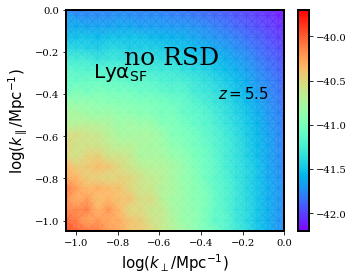

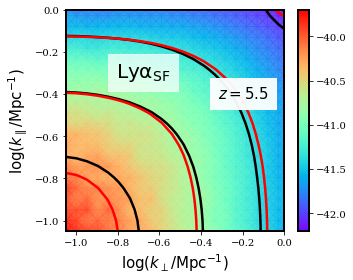


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


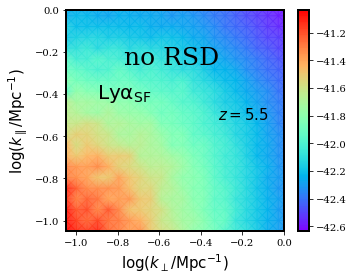

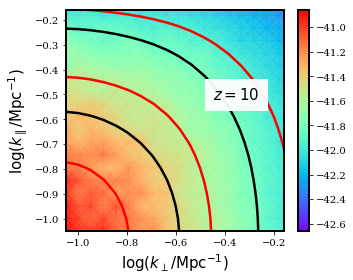


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


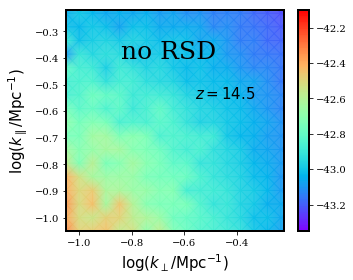

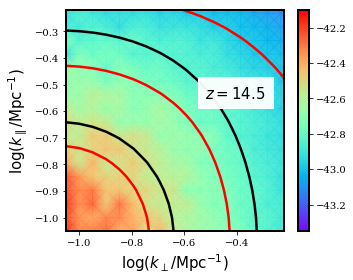

In [33]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)




plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-42.2, vmax=-39.7)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.text(-0.77,-0.26,'no RSD', fontsize = 25)
plt.text(-0.32,-0.42,r'$z=5.5$', fontsize = 15)
plt.text(-0.92,-0.32,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-42.2, vmax=-39.7)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.text(-0.81,-0.32,r'${\rm Ly\alpha_{SF}}$', fontsize = 20, bbox=dict(facecolor='white', alpha=0.73, edgecolor='white', pad=7.5))
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
#plt.text(-0.7,-0.4,'RSD', fontsize = 25)
plt.text(-0.32,-0.42,r'$z=5.5$', fontsize = 15, bbox=dict(facecolor='white', alpha=0.95, edgecolor='white', pad=7.5))
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()









path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_RSD_maxdvdr000.20_z010.09_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_z010.09_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)




plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.text(-0.77,-0.26,'no RSD', fontsize = 25)
plt.text(-0.32,-0.52,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.42,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.16)
plt.ylim(-1.05,-0.16)
#plt.text(-0.7,-0.4,'RSD', fontsize = 25)
plt.text(-0.45,-0.52,r'$z=10$', fontsize = 15, bbox=dict(facecolor='white', alpha=0.95, edgecolor='white', pad=7.5))
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()





path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-42.1, vmax=-43.35)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
plt.text(-0.84,-0.4,'no RSD', fontsize = 25)
plt.text(-0.56,-0.55,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9, vmin=-42.1, vmax=-43.35)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
#plt.text(-0.8,-0.4,'RSD', fontsize = 25)
plt.text(-0.52,-0.55,r'$z=14.5$', fontsize = 15, bbox=dict(facecolor='white', alpha=0.95, edgecolor='white', pad=7.5))
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


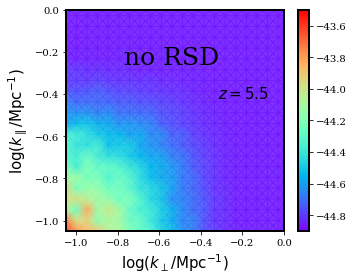

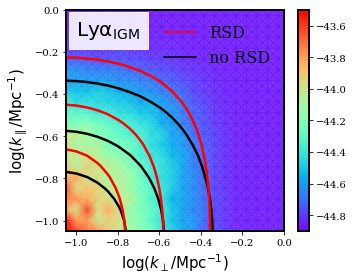


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


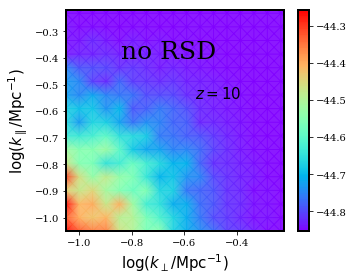

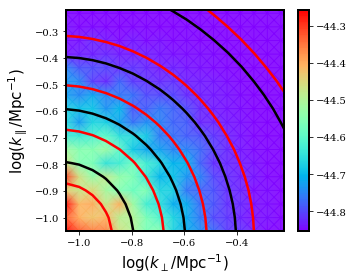


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


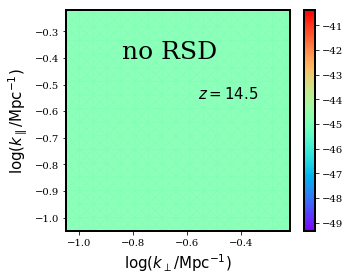

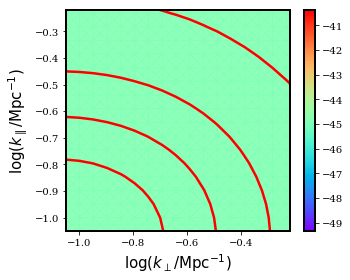

In [34]:
path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44.9, vmax=-43.5)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.text(-0.77,-0.26,'no RSD', fontsize = 25)
plt.text(-0.32,-0.42,r'$z=5.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44.9, vmax=-43.5)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.text(-1,-0.12,r'${\rm Ly\alpha_{IGM}}$', fontsize = 20, bbox=dict(facecolor='white', alpha=0.883, edgecolor='white', pad=7.5))
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.plot([],[],label='RSD',color='r')
plt.plot([],[],label='no RSD',color='k')
plt.legend(frameon=False,prop={'size': 16},facecolor='white')
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_RSD_maxdvdr000.20_z010.09_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_z010.09_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
plt.text(-0.84,-0.4,'no RSD', fontsize = 25)
plt.text(-0.56,-0.55,r'$z=10$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 8.), 4, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 8.), 4, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()







path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
plt.text(-0.84,-0.4,'no RSD', fontsize = 25)
plt.text(-0.56,-0.55,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 8.), 4, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 8.), 4, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


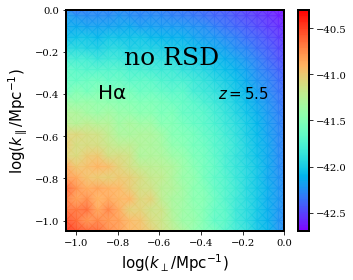

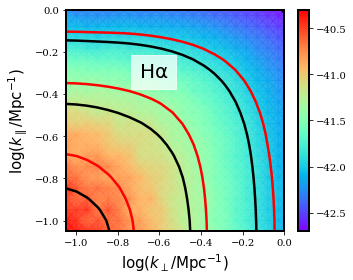


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


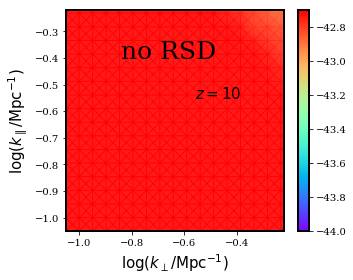

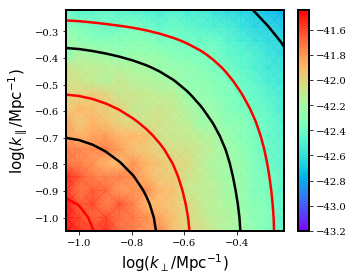


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


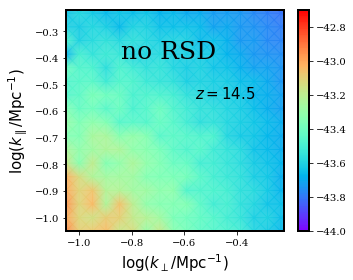

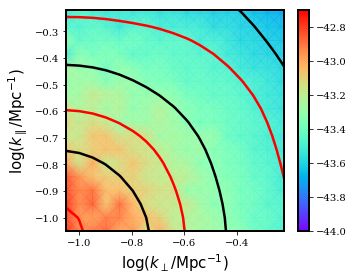

In [19]:
path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-42.7, vmax=-40.3)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.text(-0.77,-0.26,'no RSD', fontsize = 25)
plt.text(-0.32,-0.42,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.42,r'${\rm H\alpha}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-42.7, vmax=-40.3)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.text(-0.7,-0.32,r'${\rm H\alpha}$', fontsize = 20, bbox=dict(facecolor='white', alpha=0.73, edgecolor='white', pad=7.5))
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 3, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 3, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()


path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_RSD_maxdvdr000.20_z010.09_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_z010.09_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44, vmax=-42.7)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
plt.text(-0.84,-0.4,'no RSD', fontsize = 25)
plt.text(-0.56,-0.55,r'$z=10$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 3, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 3, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44, vmax=-42.7)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
plt.text(-0.84,-0.4,'no RSD', fontsize = 25)
plt.text(-0.56,-0.55,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9, vmin=-44, vmax=-42.7)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.22)
plt.ylim(-1.05,-0.22)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 3, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 3, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


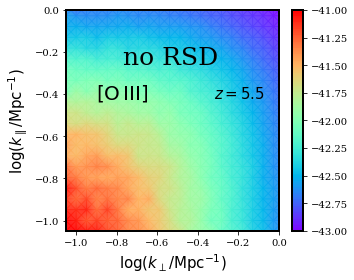

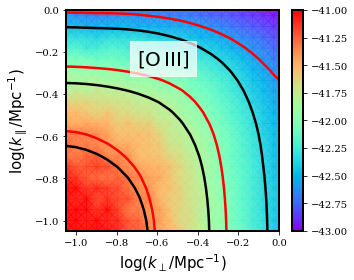


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


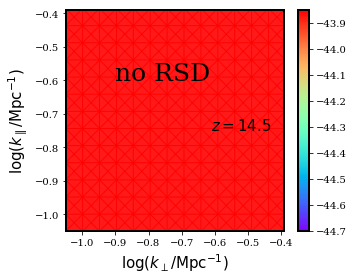

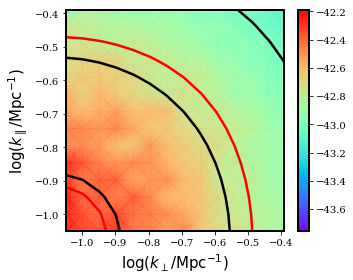


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


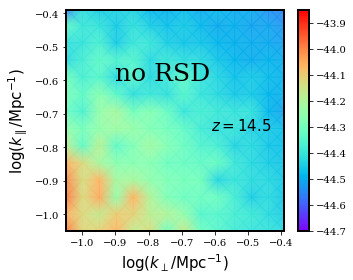

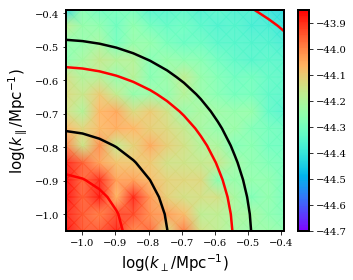

In [20]:
path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-43., vmax=-41.)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.text(-0.77,-0.26,'no RSD', fontsize = 25)
plt.text(-0.32,-0.42,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.42,r'${\rm [O\,III]}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-43., vmax=-41.)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.text(-0.7,-0.26,r'${\rm [O\,III]}$', fontsize = 20, bbox=dict(facecolor='white', alpha=0.73, edgecolor='white', pad=7.0))
plt.xlim(-1.05,-0.)
plt.ylim(-1.05,-0.)
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 3, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 3, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z010.09_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z010.09_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44.7, vmax=-43.85)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.39)
plt.ylim(-1.05,-0.39)
plt.colorbar()
plt.text(-0.9,-0.6,'no RSD', fontsize = 25)
plt.text(-0.61,-0.75,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.39)
plt.ylim(-1.05,-0.39)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()





path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmin=-44.7, vmax=-43.85)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.39)
plt.ylim(-1.05,-0.39)
plt.colorbar()
plt.text(-0.9,-0.6,'no RSD', fontsize = 25)
plt.text(-0.61,-0.75,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9, vmin=-44.7, vmax=-43.85)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.39)
plt.ylim(-1.05,-0.39)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 3.), 3, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 3.), 3, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


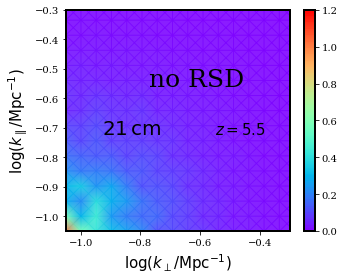

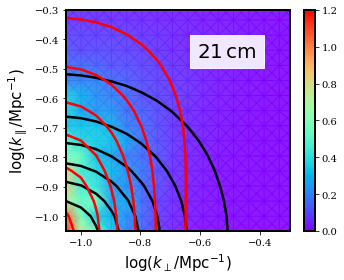


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


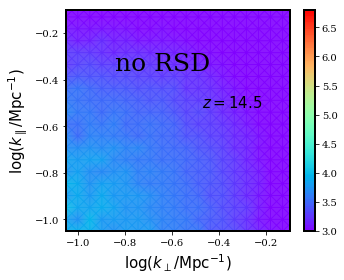

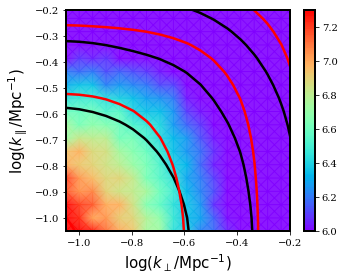


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


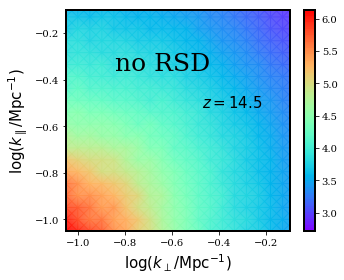

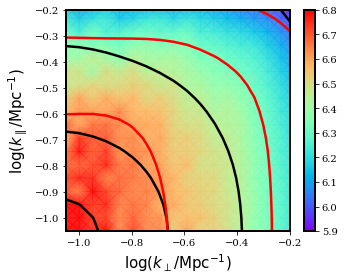

In [35]:
path_norsd1 = './limfast-master/limfast_bt/Boxes/I_21cm_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/delta_T_z005.50_nf0.024278_useTs1_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T/6000), 
               cmap='rainbow',shading='gouraud', alpha=0.9,vmax=1.2,vmin=-0)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.3)
plt.ylim(-1.05,-0.3)
plt.colorbar()
plt.text(-0.77,-0.56,'no RSD', fontsize = 25)
plt.text(-0.55,-0.72,r'$z=5.5$', fontsize = 15)
plt.text(-0.93,-0.72,r'${\rm 21\,cm}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T/6000/16000), 
               cmap='rainbow',shading='gouraud', alpha=0.9,vmax=1.2,vmin=0.)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.text(-0.61,-0.46,r'${\rm 21\,cm}$', fontsize = 20, bbox=dict(facecolor='white', alpha=0.893, edgecolor='white', pad=7.0))
plt.xlim(-1.05,-0.3)
plt.ylim(-1.05,-0.3)
plt.colorbar()
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T), 3.), 7, colors='k',linewidths=2.5,linestyles='solid',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T), 3.), 7, colors='r',linewidths=2.5,linestyles='solid',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()





path_norsd1 = './limfast-master/limfast_bt/Boxes/I_21cm_RSD_maxdvdr000.20_z010.09_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/delta_T_z010.09_nf0.839398_useTs1_200_500Mpc'



data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9, vmax=6.8, vmin=3)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.1)
plt.ylim(-1.05,-0.1)
plt.colorbar()
plt.text(-0.84,-0.36,'no RSD', fontsize = 25)
plt.text(-0.47,-0.52,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1),np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9, vmax=7.3, vmin=6.)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.2)
plt.ylim(-1.05,-0.2)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 4, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 4, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_21cm_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/delta_T_z014.52_nf0.980727_useTs1_200_500Mpc'



data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)





plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), np.log10(fofr1b.T), 
               cmap='rainbow',shading='gouraud', alpha=0.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.1)
plt.ylim(-1.05,-0.1)
plt.colorbar()
plt.text(-0.84,-0.36,'no RSD', fontsize = 25)
plt.text(-0.47,-0.52,r'$z=14.5$', fontsize = 15)
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()



plt.figure(figsize=(5,4))
#ax = plt.gca()
#plt.gca().set_facecolor("white")
#plt.setp(ax.spines.values(), color='k')
#plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1),np.log10(fofr1.T), 
               cmap='rainbow',shading='gouraud',alpha=0.9, vmax=6.8, vmin=5.9)
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.05,-0.2)
plt.ylim(-1.05,-0.2)
plt.colorbar()
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter(np.log10(fofr1b.T), 2.), 4, colors='k',linewidths=2.5, linestyles='solid',  interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter(np.log10(fofr1.T), 2.), 4, colors='r',linewidths=2.5,linestyles='solid', interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


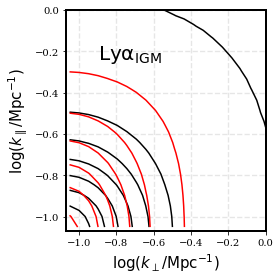


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


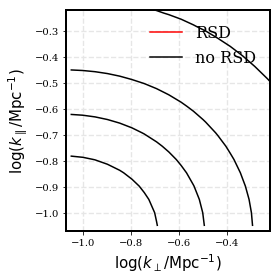

In [128]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm Ly\alpha_{IGM}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI1216AdIGM_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.22)
plt.ylim(-1.07,-0.22)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.plot([],[],label='RSD',color='r')
plt.plot([],[],label='no RSD',color='k')
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 8.), 4, colors='r',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 8.), 4, colors='k',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


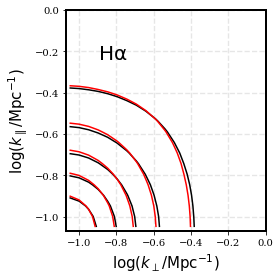


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


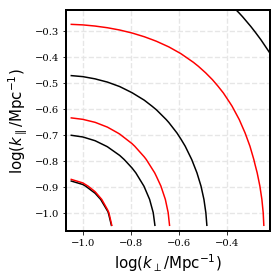

In [140]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm H\alpha}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI6563A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.22)
plt.ylim(-1.07,-0.22)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 3, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 3, colors='r',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


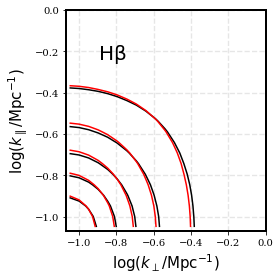

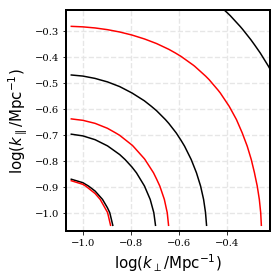

In [174]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI4861A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI4861A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm H\beta}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_HI4861A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_HI4861A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.22)
plt.ylim(-1.07,-0.22)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 3, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 3, colors='r',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


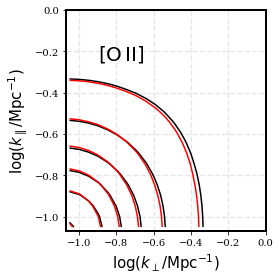


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


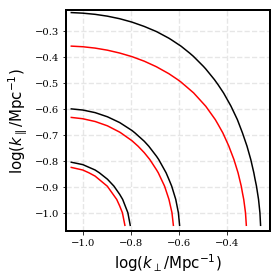

In [11]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OII3726A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OII3726A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm [O\,II]}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)



rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)



x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.22)
plt.ylim(-1.07,-0.22)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)

plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 3, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 3, colors='r',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


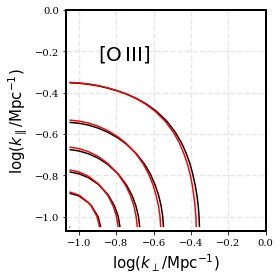


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


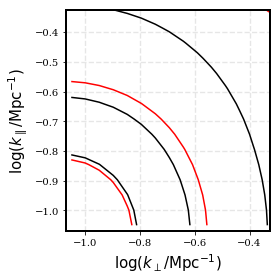

In [157]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z005.50_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm [O\,III]}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/I_OIII5007A_z014.52_HIIfilter1_RHIImax50_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)

rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.325)
plt.ylim(-1.07,-0.325)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 3, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 3, colors='r',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

/Users/masribas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


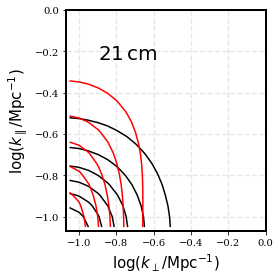


 ftrans has shape:  (101, 200, 200)

 ftrans has shape:  (101, 200, 200)


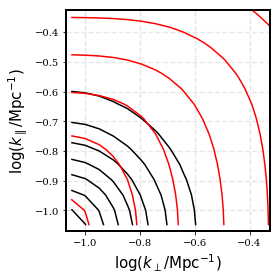

In [159]:

from scipy.ndimage.filters import gaussian_filter


"""plt.figure(figsize=(4,4))
plt.xlim(-1,0)
plt.ylim(-1,0)
plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 4, colors='r',interpolation='none')

plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()

plt.figure(figsize=(4,4))
plt.pcolormesh(np.log10(x_grid1b), np.log10(y_grid1b), (fofr1b.T)/np.max((fofr1b.T)), 
               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel})$', fontsize=15)
plt.colorbar()
plt.tight_layout()
plt.xlim(-1,0)
plt.ylim(-1,0)
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()"""

path_norsd1 = './limfast-master/limfast_bt/Boxes/I_21cm_RSD_maxdvdr000.20_z005.50_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/delta_T_z005.50_nf0.024278_useTs1_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)


rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow',shading='gouraud')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.)
plt.ylim(-1.07,-0.)
#plt.colorbar()
#plt.text(-0.32,-0.26,r'$z=5.5$', fontsize = 15)
plt.text(-0.9,-0.24,r'${\rm 21\,cm}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 6, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.), 6, colors='r',interpolation='none')
plt.tight_layout()
#plt.savefig('./CIIPS_RSD.png', dpi=200)
plt.show()




path_norsd1 = './limfast-master/limfast_bt/Boxes/I_21cm_RSD_maxdvdr000.20_z014.52_HIIfilter1_RHIImax50_200_500Mpc'
path_rsd1 = './limfast-master/limfast_bt/Boxes/delta_T_z014.52_nf0.980727_useTs1_200_500Mpc'

data1 = CreateDataCube(path_norsd1)
data1b = CreateDataCube(path_rsd1)

rmid_prp1, rmid_par1, fofr1 = get_2dps(500./200., 200, data1)
rmid_prp1b, rmid_par1b, fofr1b = get_2dps(500./200., 200, data1b)

x_grid1, y_grid1 = np.meshgrid(rmid_prp1, rmid_par1)
x_grid1b, y_grid1b = np.meshgrid(rmid_prp1b, rmid_par1b)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.gca().set_facecolor("white")
plt.setp(ax.spines.values(), color='k')
plt.grid(True,color='0.9',linestyle='dashed',linewidth=1.4)
#plt.pcolormesh(np.log10(x_grid1), np.log10(y_grid1), (fofr1.T)/np.max((fofr1.T)), 
#               cmap='rainbow')
plt.xlabel(r'$\log(k_{\perp}/{\rm Mpc^{-1}})$', fontsize=15)
plt.ylabel(r'$\log(k_{\parallel}/{\rm Mpc^{-1}})$', fontsize=15)
plt.xlim(-1.07,-0.325)
plt.ylim(-1.07,-0.325)
#plt.colorbar()
#plt.text(-0.55,-0.34,r'$z=14.5$', fontsize = 15)
#plt.text(-0.49,-0.34,r'${\rm Ly\alpha_{SF}}$', fontsize = 20)
plt.contour(np.log10(x_grid1b), np.log10(y_grid1b), gaussian_filter((fofr1b.T)/np.max((fofr1b.T)), 3.), 7, colors='k',interpolation='none')
plt.contour(np.log10(x_grid1), np.log10(y_grid1), gaussian_filter((fofr1.T)/np.max((fofr1.T)), 3.),7, colors='r',interpolation='none')
plt.tight_layout()
plt.legend(frameon=False,prop={'size': 16})
#plt.savefig('./CIIPS_RSD.png', dpi=200)


plt.show()